In [2]:
#Colab setting
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/DSAIL')

import os
os.chdir('/content/drive/My Drive/DSAIL')

Mounted at /content/drive


In [3]:
# Data U1.base로 train, u1.test로 test data만들기
# U.data는 현재 (["user_id", "movie_id", "rating", "timestamp"])로 구성
import pandas as pd
import torch
import numpy as np

test = np.load("continous_test.npy")
train = np.load("continous_train.npy")

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device", device)


device cpu


In [3]:
a = [-1, -2, 3]
a = np.array(a)
b = (a > 0).astype(float)
print(b)

[0. 0. 1.]


In [8]:
import torch.nn as nn
import torch.optim as optim

class SVDpp(nn.Module):
  def __init__(self, train_R, test_R, d=50, learning_rate=5e-4, epochs=100, reg = 0.01, device=device):
    '''
    SVD++
    pytorch version
    '''
    super(SVDpp, self).__init__()

    self.n, self.m = train_R.shape
    self.test_n, self.test_m = test_R.shape
    self.device = device
    self.latent_dimension = d

    self.train_R = torch.tensor(train_R, dtype=torch.float32, device=device)
    self.test_R = torch.tensor(test_R, dtype=torch.float32, device=device)

    self.train_implicit = (train_R > 0).astype(float)
    self.test_implicit = (test_R > 0).astype(float)
    self.N_train = np.sum(self.train_implicit, axis=1)
    self.N_test = np.sum(self.test_implicit, axis=1)

    # sigma yj 더할 때 사용할 index들 (N(u)에 속한 item index)
    self.Nu_Y_train = {user: np.where(self.train_implicit[user, :] > 0)[0] for user in range(self.n)}
    self.Nu_Y_test = {user: np.where(self.test_implicit[user, :] > 0)[0] for user in range(self.test_n)}


    self.lr = learning_rate
    self.epoch = epochs
    self.reg = reg

    print("Number of User:", self.n)
    print("Number of Movies:", self.m)
    print("Shape of train_R:", self.train_R.shape)
    print("Shape of test_R:", self.test_R.shape)

    # parameters
    self.P = nn.Parameter(torch.rand(self.n, self.latent_dimension, device=device) * (1.0 / self.latent_dimension))
    self.Q = nn.Parameter(torch.rand(self.m, self.latent_dimension, device=device) * (1.0 / self.latent_dimension))
    self.Y = nn.Parameter(torch.rand(self.m, self.latent_dimension, device=device) * (1.0 / self.latent_dimension))

    self.bu = nn.Parameter(torch.rand(self.n, device=device))
    self.bi = nn.Parameter(torch.rand(self.m, device=device))
    self.mu = torch.mean(self.train_R[self.train_R != 0])

  def forward(self, u, i):
    nu_1_2 = 1 / np.sqrt(self.N_train[u])
    # Y 연산은 item끼리 더해야됨 axis = 0 [[item1], [item2]] => [item1 + item2]
    return self.mu + self.bu[u] + self.bi[i] + torch.matmul(self.P[u, :] + nu_1_2 * torch.sum(self.Y[self.Nu_Y_train[u], :], axis = 0), self.Q[i, :])

  def loss(self, u, i, train = True):
    predicted_R = self.forward(u, i)
    if train:
      return (self.train_R[u, i] - predicted_R).pow(2)
    else:
      return (self.test_R[u, i] - predicted_R).pow(2)


  def fit(self):
    train_loss_list = []
    test_loss_list = []

    optimizer = optim.SGD(self.parameters(), lr=self.lr)

    for epoch in range(self.epoch):
      total_loss = 0
      test_loss = 0
      num_entries = 0
      num_test_entries = 0

      for u in range(self.n):
        for i in range(self.m):
          if self.train_R[u, i]:
            #optimizer.zero_grad()
            loss = self.loss(u, i)
            #loss.backward()
            #optimizer.step()
            total_loss += loss
            num_entries += 1

      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      with torch.no_grad():
        for uu in range(self.test_n):
          for ii in range(self.test_m):
            if self.test_R[uu, ii]: # test rmse
              test_loss += self.loss( uu, ii, train = False)
              num_test_entries += 1

      optimizer.zero_grad()

      rmse = torch.sqrt(total_loss / num_entries)
      test_rmse =np.sqrt(test_loss / num_test_entries)
      train_loss_list.append(rmse)
      test_loss_list.append(test_rmse)

      #if epoch % 20 == 0:
      print(f'Epoch [{epoch}/{self.epoch}], train_loss: {rmse}, test_loss: {test_rmse}')
    return train_loss_list, test_loss_list


Number of User: 943
Number of Movies: 1682
Shape of train_R: torch.Size([943, 1682])
Shape of test_R: torch.Size([462, 1591])
Epoch [0/10], train_loss: 1.7675917148590088, test_loss: 1.483742594718933
Epoch [1/10], train_loss: 1.4790434837341309, test_loss: 1.3011555671691895
Epoch [2/10], train_loss: 1.2380865812301636, test_loss: 1.1894664764404297
Epoch [3/10], train_loss: 1.1281307935714722, test_loss: 1.1488085985183716
Epoch [4/10], train_loss: 1.0894293785095215, test_loss: 1.1168485879898071
Epoch [5/10], train_loss: 1.058601975440979, test_loss: 1.0911108255386353
Epoch [6/10], train_loss: 1.0339202880859375, test_loss: 1.0705755949020386
Epoch [7/10], train_loss: 1.01438307762146, test_loss: 1.0542513132095337
Epoch [8/10], train_loss: 0.9988652467727661, test_loss: 1.0411819219589233
Epoch [9/10], train_loss: 0.9864007830619812, test_loss: 1.03057062625885


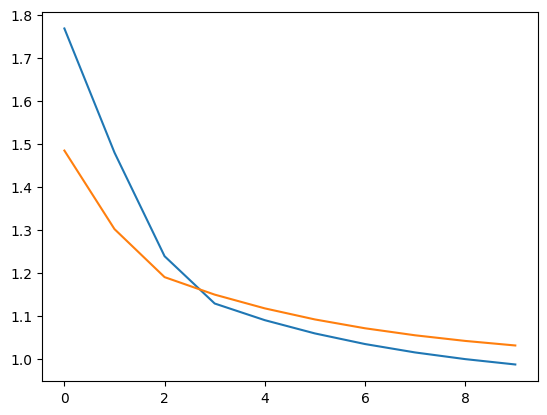

In [9]:
import matplotlib.pyplot as plt

model = SVDpp(train_R = train, test_R = test, d=10, learning_rate = 5e-4, epochs= 10)

# Train the model
train_loss_list, test_loss_list = model.fit()
train_loss_tensor = torch.tensor(train_loss_list, dtype=torch.float32)
plt.plot(train_loss_tensor.cpu().numpy())
test_loss_tensor = torch.tensor(test_loss_list, dtype=torch.float32)
plt.plot(test_loss_tensor.cpu().numpy())

Epoch 최소 100회는 해야

optimizer.zero_grad()를 해줘야 gradient를 0으로 초기화
predict 일일이 하는 것보다는 matrix 전체구해서 loss 구하는게 더 빠를듯!

loss.item() 하면 Tensor가 아니라 float로 들어와서 backward()가 불가능함

처음에 느렸던 이유

-> loss 계산할 때 train_R을 넘겨줬는데 이것 때문에 RAM 용량 부족해진듯 !
